<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Deep Learning</center>

# Challenge S2: Machine Learning Basics en TensorFlow

## Objetivos

El objetivo de este challenge es familiarizarnos con TensorFlow y con su funcionamiento básico enfrentandose a problemas de regresión y clasificación.


## Regresión

### Punto de partida

El punto de partida se corresponde con el código que hemos visto en el worksheet:

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# Cargamos el dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

# Creamos las estructuras que contienen las categorías
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # lista de todos los valores únicos contenidos en una columna
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Definimos nuestra función de input

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # función interna, esto es lo que será devuelto
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # crea un objeto tf.data.Dataset que contendrá datos y etiquetas 
    if shuffle:
      ds = ds.shuffle(1000)  # con esta línea aleatorizamos la selección de elementos
    ds = ds.batch(batch_size).repeat(num_epochs)  # divide el dataset en batches el número de veces especificado por num_epocs 
    return ds  # devuelve un batch del dataset
  return input_function  # devuelve el objeto completo para ser utilizado.

train_input_fn = make_input_fn(dftrain, y_train)  # así llamamos a la función que se nos devuelve para extraer el objeto dataset que inyectaremos en el modelo
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


# Creamos el modelo
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

# Lo entrenamos
linear_est.train(train_input_fn)  # entrenamos el modelo
result = linear_est.evaluate(eval_input_fn)  # obtenemos las estimaciones del conjunto de evaluación

clear_output()  # limpiamos la consola
print(result['accuracy'])  # la viariable result es un diccionario con los resultados de nuestro modelo

0.74242425


## Tareas


### Cambiando el histograma

En el worksheet tenemos el ejemplo de un histograma con las posibilidades de supervivencia de cada individuo del conjunto de evaluación, representad a continuación el mismo histograma pero con el conjunto de entrenamiento.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/01/4d70j3nn55z71b4011q5p56r0000gn/T/tmpfninx4qc/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

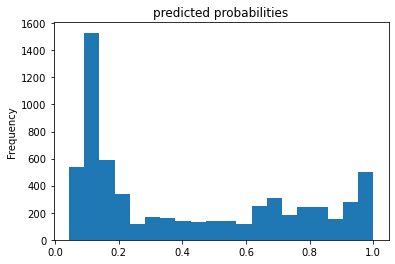

In [2]:
pred_dicts = list(linear_est.predict(train_input_fn)) 

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

¿Y si lo que queremos es pintar el histograma de la mortalidad de cada individuo del conjunto de evaluación?

Pista, mirad la estructura del diccionario que devuelve *linear_est.predict()*

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/01/4d70j3nn55z71b4011q5p56r0000gn/T/tmpfninx4qc/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

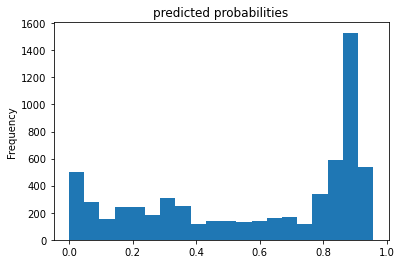

In [3]:
pred_dicts = list(linear_est.predict(train_input_fn)) 

probs = pd.Series([pred['probabilities'][0] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

### Cambiando el conjunto de entrenamiento

Sabemos que uno de los factores más importantes en el entrenamiento de redes neuronales es la cantidad y calidad del conjunto de entrenamiento. ¿Es igual de importante en regresión lineal?

Vamos a ver cuál sería el porcentaje de acierto de nuestro modelo si entrenamos con la mitad del conjunto de entrenamiento:

In [12]:
df_train_mid = dftrain.iloc[0:313]


Y si entrenamos con una décima parte de en nuestro ejemplo original?

Por último, vamos a mostrar también el accuracy que tenemos sobre el conjunto de datos de entrenamiento (podemos utilizar cualquiera de los modelos que acabamos de entrenar)


### Conclusiones:
 
¿Hay mucha diferencia entre el entrenamiento original y el que hemos realizado con datos diezmados? ¿Por qué?

## Regresión

### Punto de partida

El punto de partida se corresponde con el código que hemos visto en el worksheet:

In [2]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
train_y = train.pop('Species')
test_y = test.pop('Species')

def input_fn(features, labels, training=True, batch_size=256):
    # Convertimos los datos al tipo dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Aleatorizamos y seleccionamos los datos si estamos en modo train.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

# Feature columns describe cómo se utilizan las feature columns
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

# Definimos una DNN con 2 capas ocultas con 30 y 10 nodos ocultos cada una.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Dos capas ocultas de 30 y 10 nodos respectivamente
    hidden_units=[10,10,10],
    # El modelo debe poder distinguir entre 3 clases
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# Hemos definido lambda para evitar crear una función previamente (los detalles de implementación no son importantes ahora)


eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))





[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/b0/rhdddf2s1bq1_qtznbxn4m_m0000gn/T/tmpvk8ezqos', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_expe

### Ajustando los parámetros del entrenamiento

Como sabemos, el número de capas y neuronas ocultas es un número arbitrario y necesitamos de muchos experimentos y test para poder determinar la mejor elección de estos valores.

Vamos a probar en las siguientes celdas a probar las siguientes arquitecturas:

- 1 capa oculta de 10 neuronas
- 1 capa oculta de 50 neuronas
- 2 capas ocultas de 30 y 10 neuronas respectivamente
- 3 capas ocultas de 30, 20 y 10 neuronas respectivamente.
- 5 capas ocultas de 30, 20, 10, 10 y 10 neuronas respectivamente.


### Conclusiones

¿Qué idea básica extraes de los experimentos?

¿Mejora siempre la red al aumentar su tamaño y/o profundidad?
